In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import pandas as pd
from scipy import stats

from torch.utils.data import random_split

from statsforecast import StatsForecast

In [49]:
from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveMean,
    NaiveDrift,
    ExponentialSmoothing,
    AutoARIMA,
    ARIMA,
    Theta,
    FFT
)

from darts.metrics import mase, mse, mae, ope

In [ ]:
from statsforecast.models import WindowAverage

Change working directory

In [11]:
notebook_path = %pwd

os.chdir(Path(notebook_path).parent)
os.getcwd()

'/home/atleeri/repositories/forecast-electricity-markets'

Load processed data

In [12]:
processed_data_dir = Path('data/processed')
filepaths = list(processed_data_dir.glob('**/*60*.parquet'))
filepaths

[PosixPath('data/processed/opsd-time_series-2020-10-06/time_series_60min_singleindex.parquet')]

In [76]:
filepath = filepaths[0]
df = pd.read_parquet(filepath)
df

,utc_timestamp,cet_cest_timestamp,DE_wind_generation,DE_price_ahead
0,2014-12-31 23:00:00+00:00,2015-01-01 00:00:00+01:00,NaN,NaN
1,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+01:00,8852.0,NaN
2,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+01:00,9054.0,NaN
3,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+01:00,9070.0,NaN
4,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+01:00,9163.0,NaN
...,...,...,...,...
50396,2020-09-30 19:00:00+00:00,2020-09-30 20:00:00+01:00,10654.0,49.92
50397,2020-09-30 20:00:00+00:00,2020-09-30 21:00:00+01:00,11836.0,42.79
50398,2020-09-30 21:00:00+00:00,2020-09-30 22:00:00+01:00,12168.0,35.02
50399,2020-09-30 22:00:00+00:00,2020-09-30 23:00:00+01:00,12533.0,34.40


#### Sample and Plot Data

In [77]:
df_sample = df.sample(n=len(df), random_state=2025)

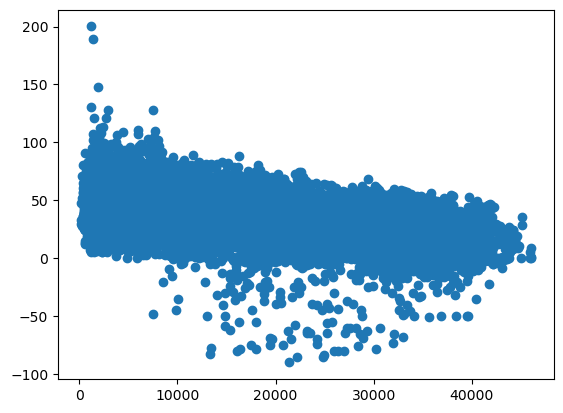

In [78]:
valid_mask = df_sample['DE_wind_generation'].notna() & df_sample['DE_price_ahead'].notna()
plt.scatter(df_sample[valid_mask]['DE_wind_generation'], df_sample[valid_mask]['DE_price_ahead'])

In [79]:
df_sample

,utc_timestamp,cet_cest_timestamp,DE_wind_generation,DE_price_ahead
20095,2017-04-17 06:00:00+00:00,2017-04-17 07:00:00+01:00,6150.0,NaN
47699,2020-06-10 10:00:00+00:00,2020-06-10 11:00:00+01:00,3769.0,34.90
48713,2020-07-22 16:00:00+00:00,2020-07-22 17:00:00+01:00,3007.0,42.19
46775,2020-05-02 22:00:00+00:00,2020-05-02 23:00:00+01:00,12000.0,18.00
18157,2017-01-26 12:00:00+00:00,2017-01-26 13:00:00+01:00,9436.0,NaN
...,...,...,...,...
15948,2016-10-26 11:00:00+00:00,2016-10-26 12:00:00+01:00,1797.0,NaN
11102,2016-04-07 13:00:00+00:00,2016-04-07 14:00:00+01:00,17177.0,NaN
16338,2016-11-11 17:00:00+00:00,2016-11-11 18:00:00+01:00,3593.0,NaN
32478,2018-09-15 05:00:00+00:00,2018-09-15 06:00:00+01:00,13707.0,NaN


### Split sample into train, validation, and test data

In [80]:
# Keep only rows with valid price data
#df = df.dropna(subset=['DE_price_ahead'])
# Then do your train/test split


train_len = int(0.7*len(df))
val_len = int(0.15*len(df))
test_len = len(df)-train_len-val_len

df_train, df_val, df_test = df[:train_len], df[train_len:train_len+val_len], df[train_len+val_len:]

In [81]:
# Create a dataframe with columns in format required by statsforecast
df_train_reformat = pd.DataFrame({
    'unique_id': 'DE_wind_generation',
    'utc_timestamp_no_tz': df_train['utc_timestamp'].dt.tz_localize(None),  # Remove timezone
    'DE_price_ahead': df_train['DE_price_ahead']
})

In [82]:
df_train_reformat.head(5)

,unique_id,utc_timestamp_no_tz,DE_price_ahead
0,DE_wind_generation,2014-12-31 23:00:00,NaN
1,DE_wind_generation,2015-01-01 00:00:00,NaN
2,DE_wind_generation,2015-01-01 01:00:00,NaN
3,DE_wind_generation,2015-01-01 02:00:00,NaN
4,DE_wind_generation,2015-01-01 03:00:00,NaN


In [86]:
ts_train = df_train_reformat[['utc_timestamp_no_tz', 'DE_price_ahead']].set_index('utc_timestamp_no_tz')['DE_price_ahead']
ts_train.index.name = 'timestamp'
ts_train

timestamp
2014-12-31 23:00:00      NaN
2015-01-01 00:00:00      NaN
2015-01-01 01:00:00      NaN
2015-01-01 02:00:00      NaN
2015-01-01 03:00:00      NaN
                       ...  
2019-01-09 18:00:00    54.19
2019-01-09 19:00:00    52.98
2019-01-09 20:00:00    51.68
2019-01-09 21:00:00    48.95
2019-01-09 22:00:00    47.63
Name: DE_price_ahead, Length: 35280, dtype: float64

In [87]:
ts_train = TimeSeries.from_series(ts_train, freq='H')
#ts_val = TimeSeries.from_series(ts_val)
#ts_test = TimeSeries.from_series(ts_test)

/home/atleeri/repositories/forecast-electricity-markets/.pixi/envs/default/lib/python3.12/site-packages/darts/timeseries.py:5146: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_times = resampled_times.asfreq(freq)


In [89]:
ts_train.shape

(35280, 1, 1)

In [88]:
model =  ExponentialSmoothing()#AutoARIMA(seasonal=True)#NaiveSeasonal(24)#WindowAverage(2)
model.fit(ts_train)
y_pred = model.predict(24)
y_pred

/home/atleeri/repositories/forecast-electricity-markets/.pixi/envs/default/lib/python3.12/site-packages/statsmodels/tsa/exponential_smoothing/initialization.py:95: RuntimeWarning: Mean of empty slice
  initial_seasonal = np.nanmean(


ValueError: shapes (2,10) and (0,1) not aligned: 10 (dim 1) != 0 (dim 0)

In [63]:
y_pred.values()

array([[35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98],
       [35.98]])

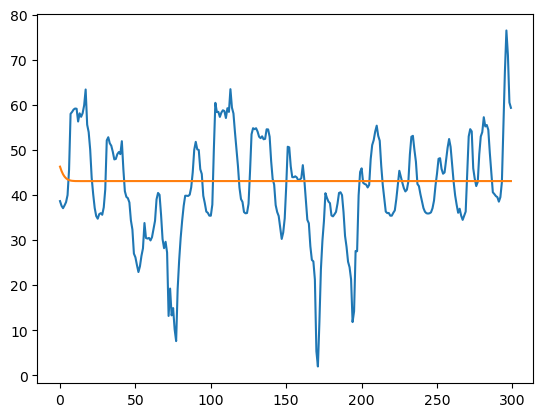

In [52]:
plt.plot(df_test['DE_price_ahead'].values[:300])
plt.plot(y_pred.values()[:300,0])

In [99]:
# Create a dataframe with columns in format required by 
df_train_reformat = pd.DataFrame({
    'unique_id': 'DE_wind_generation',
    'utc_timestamp_no_tz': df_train['utc_timestamp'].dt.tz_localize(None),  # Remove timezone
    'DE_price_ahead': df_train['DE_price_ahead']
})

# Remove rows with NaN in target
df_train_reformat = df_train_reformat.dropna(subset=['DE_price_ahead'])

sf = StatsForecast(
    models = [
        AutoARIMA(),
    ],
    freq = "H",
    n_jobs = 1, # how many CPU cores to use in parallel
)

sf.fit(
    df=df_train_reformat,
    id_col='unique_id',
    time_col='utc_timestamp_no_tz',
    target_col='DE_price_ahead'
)

StatsForecast(models=[AutoARIMA])

In [100]:
df_test_pred = sf.forecast(
    h=len(df_test),
    df=df_train_reformat,
    id_col='unique_id',
    time_col='utc_timestamp_no_tz',
    target_col='DE_price_ahead',
)

/home/atleeri/repositories/forecast-electricity-markets/.pixi/envs/default/lib/python3.12/site-packages/utilsforecast/processing.py:378: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/atleeri/repositories/forecast-electricity-markets/.pixi/envs/default/lib/python3.12/site-packages/utilsforecast/processing.py:434: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


Manual Moving Average

In [55]:
df_train_reformat['DE_price_ahead']

32856    56.10
32857    51.41
32858    47.38
32859    47.59
32860    51.61
         ...  
35275    54.19
35276    52.98
35277    51.68
35278    48.95
35279    47.63
Name: DE_price_ahead, Length: 2424, dtype: float64

In [94]:
window_size = 10
forecast = []

# calculate moving average forecast
for i in range(len(df_test)):
    pred_mov_avg = df_test['DE_price_ahead'][i:(i+window_size)].mean()
    forecast.append(pred_mov_avg)

# add padding at the start to compensate for shift to the left. Ignore padded region when comparing
forecast = [0]*int(window_size / 2) + forecast
forecast

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 np.float64(49.34266666666667),
 np.float64(50.64333333333334),
 np.float64(52.12800000000001),
 np.float64(53.88333333333334),
 np.float64(55.077333333333335),
 np.float64(56.11266666666667),
 np.float64(56.785999999999994),
 np.float64(56.66466666666667),
 np.float64(55.474666666666664),
 np.float64(54.05466666666666),
 np.float64(52.47933333333332),
 np.float64(50.85),
 np.float64(49.291333333333334),
 np.float64(47.93533333333333),
 np.float64(46.43533333333334),
 np.float64(45.09666666666668),
 np.float64(43.96933333333334),
 np.float64(43.452000000000005),
 np.float64(42.746),
 np.float64(42.47),
 np.float64(42.268666666666675),
 np.float64(42.23533333333333),
 np.float64(42.50866666666666),
 np.float64(43.03200000000001),
 np.float64(43.82733333333333),
 np.float64(44.774),
 np.float64(45.728666666666655),
 np.float64(46.80733333333333),
 np.float64(47.46133333333333),
 np.float64(47.80933333333333),
 np.float64(47.963999999999984),
 np.float64(47.833

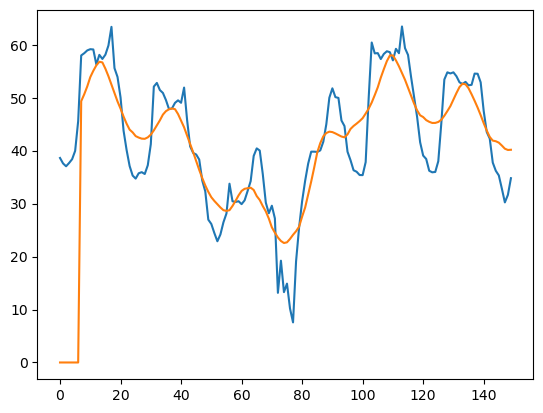

In [96]:
plt.plot(df_test['DE_price_ahead'].values[:150])
plt.plot(forecast[:150])

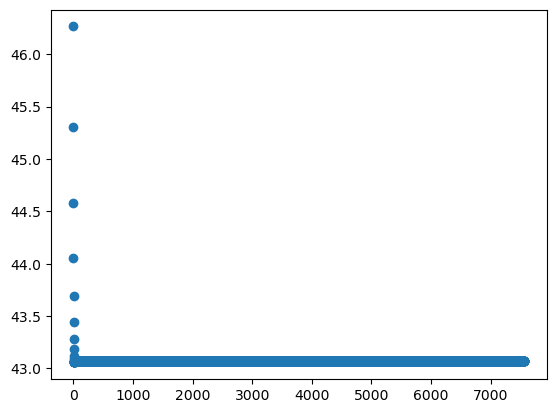

In [35]:
plt.plot(y_pred['AutoARIMA'], 'o')

In [53]:
y_pred['WindowAverage'].unique()

array([48.29])

In [52]:
y_pred

,unique_id,utc_timestamp_no_tz,AutoARIMA,WindowAverage
0,DE_wind_generation,2019-01-09 23:00:00,46.264216,48.29
1,DE_wind_generation,2019-01-10 00:00:00,45.304116,48.29
2,DE_wind_generation,2019-01-10 01:00:00,44.579100,48.29
3,DE_wind_generation,2019-01-10 02:00:00,44.054643,48.29
4,DE_wind_generation,2019-01-10 03:00:00,43.689062,48.29
...,...,...,...,...
7556,DE_wind_generation,2019-11-20 19:00:00,43.067063,48.29
7557,DE_wind_generation,2019-11-20 20:00:00,43.067063,48.29
7558,DE_wind_generation,2019-11-20 21:00:00,43.067063,48.29
7559,DE_wind_generation,2019-11-20 22:00:00,43.067063,48.29
